In [3]:
import osmnx as ox
import folium
import networkx as nx
import matplotlib.colors as colors
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.neighbors import KDTree

city_color = 'b'
city_color2 = '#FF1493'
area_color = 'k'
route1_color = 'r'
route2_color = 'g'
route_thickness = 12
print_at_end = True

town_name = 'Leonia, NJ'
map_size = 10000 # in meters. This is how much "surrounding area" we consider, as measured from the town's centroid

# location to save the maps
file_path = town_name.replace(' ','_')
if not os.path.exists(file_path):
    os.mkdir(file_path) 

In [4]:
# get the town
ox.config(use_cache=True, log_console=True)
town = ox.graph_from_place(town_name, network_type='drive')
# show it, save it
if not print_at_end:
    fig, ax = ox.plot_graph(ox.project_graph(town), edge_color=city_color, fig_height=20)
    fig.savefig('%s/town.png' % file_path)
# the town: 

In [5]:
# we want more than the town though, because we care about cutting it off from the outside, so we need to know about 
# the surrounding area.

# get the nodes and edges as data frames 
town_nodes, town_edges = ox.graph_to_gdfs(town)
                              
# get graph centroid and we'll grab everything within in map_size meters of it. For bigger towns this will need to be
# a bigger number.
#todo: can we set this imperically?
x, y = town_edges.unary_union.centroid.xy
graph_centroid = (y[0], x[0])
# G is the surrounding area and the town.
G = ox.graph_from_point(graph_centroid, distance=map_size,  network_type='drive')

town_node_ids = set(town.nodes())

for u, v, d in G.edges(data=True):
    d['edge_color'] = city_color if u in town_node_ids or v in town_node_ids else area_color
    d['edge_color2'] = city_color2 if u in town_node_ids or v in town_node_ids else area_color
    d['in_town'] = True if u in town_node_ids or v in town_node_ids else False# in town.edges() else False

# color the edges in town blue, black out of town
# ec = ['b' if e in town.edges() else 'k' for e in G.edges()]
# show it, save it
nodes, edges = ox.graph_to_gdfs(G)
if not print_at_end:
    fig, ax = ox.plot_graph(G ,fig_height=50, fig_width=50, edge_color=edges['edge_color'],  node_size=0)
    fig.savefig('%s/area.pdf' % file_path)



In [6]:
# # so now that we have the graph, let's see how to cut it off
# # Task 1: isolate the town!
# # psudo code:
# # for every node in the town
#     # if it has an edge to something outside the town:
#         # color that edge red!  
# # we're working with dataframes though, so we're not gonna use loops here and instead leverage the data structure
# nodes, edges = ox.graph_to_gdfs(G) # <- gets the nodes and edges as dataframes

# # we want to check which nodes are in town and which aren't, so we make a set to make this fast and easy
# town_node_ids = set(town.nodes())

# # We want to mark each edge coming into/out of town. That is, each edge where one of it's nodes (u & v)
# # is in town and the other out of town
# # make a new data frame column for if v is in town (t/f)
# edges['v_in_town'] = edges['v'].isin(town_node_ids)
# # make a new data frame column for if u is in town
# edges['u_in_town'] = edges['u'].isin(town_node_ids)
# # make a new data frame column for if both u and v are in town (edges that are completely in town)
# edges['in_town'] = edges['v_in_town'] & edges['u_in_town']
# # make a new data frame column for the edges (roads) coming in/out of town that we should block
# edges['block'] = (edges['v_in_town'] & ~ edges['u_in_town']) | (edges['u_in_town'] & ~ edges['v_in_town'])

# # this is how we color code them red if we should block, blue if fully in town, otherwise black
# conditions = [(edges['block']), (edges['in_town'])]
# choices = ['b', 'b']
# edges['edge_color'] = np.select(conditions, choices, default='k')
# #print('number of edges to block: %d' % (edges['edge_color'].value_counts()['r']))

# # turn the dataframes back into a graph
# Gs = ox.gdfs_to_graph(nodes, edges)
# # grab the edges, as ordered by G (the correct order is needed for coloring)
# nodes, edges = ox.graph_to_gdfs(Gs)
# # show it save it
# fig, ax = ox.plot_graph(Gs,fig_height=50, fig_width=50, edge_color=edges['edge_color'],  node_size=0)
# fig.savefig('%s/isolate.pdf' % file_path, dpi=1000, format='pdf')


In [7]:
# This is the path as is, through the town
origin = ox.geocode('703 Main St, Paterson, NJ 07503')
tree = KDTree(nodes[['y', 'x']], metric='euclidean')
origin = tree.query([origin], k=1, return_distance=False)[0]
origin = nodes.iloc[origin].index.values[0]

dest = ox.geocode('1805 Webster Ave, Bronx, NY 10457')
dest = tree.query([dest], k=1, return_distance=False)[0]
dest = nodes.iloc[dest].index.values[0]

# l, u1, v1 = ox.get_nearest_edge(G, (40.874091, -73.994518))
for u, v, d in G.edges(data=True):
    d['weight'] = d['length']*0.1 if d['highway'] == 'motorway' or d['highway'] == 'highway' else d['length']
    if 'name' in d and 'New Jersey Turnpike' in d['name']:
        d['weight'] = d['length']* 100000
    

    
route1 = nx.shortest_path(G, origin, dest, weight='weight')

if not print_at_end:
    fig, ax = ox.plot_graph_route(G, 
                              route1, route_color=route1_color, fig_height=50, 
                              fig_width=50, 
                              show=True, close=False, 
                              edge_color=edges['edge_color'],
                              route_linewidth = route_thickness, node_size=0)
                              #edge_color='#2c2c49',
                              #orig_dest_node_color='#672636',
                              #route_color='#672636', bgcolor='#0d0043', 
                              

    fig.savefig('%s/problem.pdf' % file_path, dpi=1000, format='pdf')

In [8]:
# now we penalize roads in town
for u, v, d in G.edges(data=True):
    d['weight'] = d['length']*2 if d['in_town'] else d['length'] # d['highway'] == 'residential' and
# for u, v, d in G.edges(data=True):
#     if 'name' in d and 'Fort Lee Road' in d['name']:
#         print(d)
#         print((u,v) in town.edges())

route2 = nx.shortest_path(G, origin, dest, weight='weight')
if not print_at_end:
    fig, ax = ox.plot_graph_route(G,route2, route_color=route2_color, fig_height=50, fig_width=50, 
                                   edge_color=edges['edge_color'], node_size=0,
                                   show=True, close=False, route_linewidth = [route_thickness,route_thickness]) 


    fig.savefig('%s/fixed.pdf' % file_path, dpi=1000, format='pdf')

In [9]:
# plot the together
rc1 = [route1_color] * (len(route1) - 1)
rc2 = [route2_color] * len(route2)
rc = rc1 + rc2
if not print_at_end:
    fig, ax = ox.plot_graph_routes(G, [route1, route2], route_color=rc, fig_height=50, fig_width=50, 
                                   edge_color=edges['edge_color'], node_size=0,
                                   show=True, close=False, route_linewidth = [route_thickness,route_thickness]) 
    fig.savefig('%s/both.pdf' % file_path, dpi=1000, format='pdf')

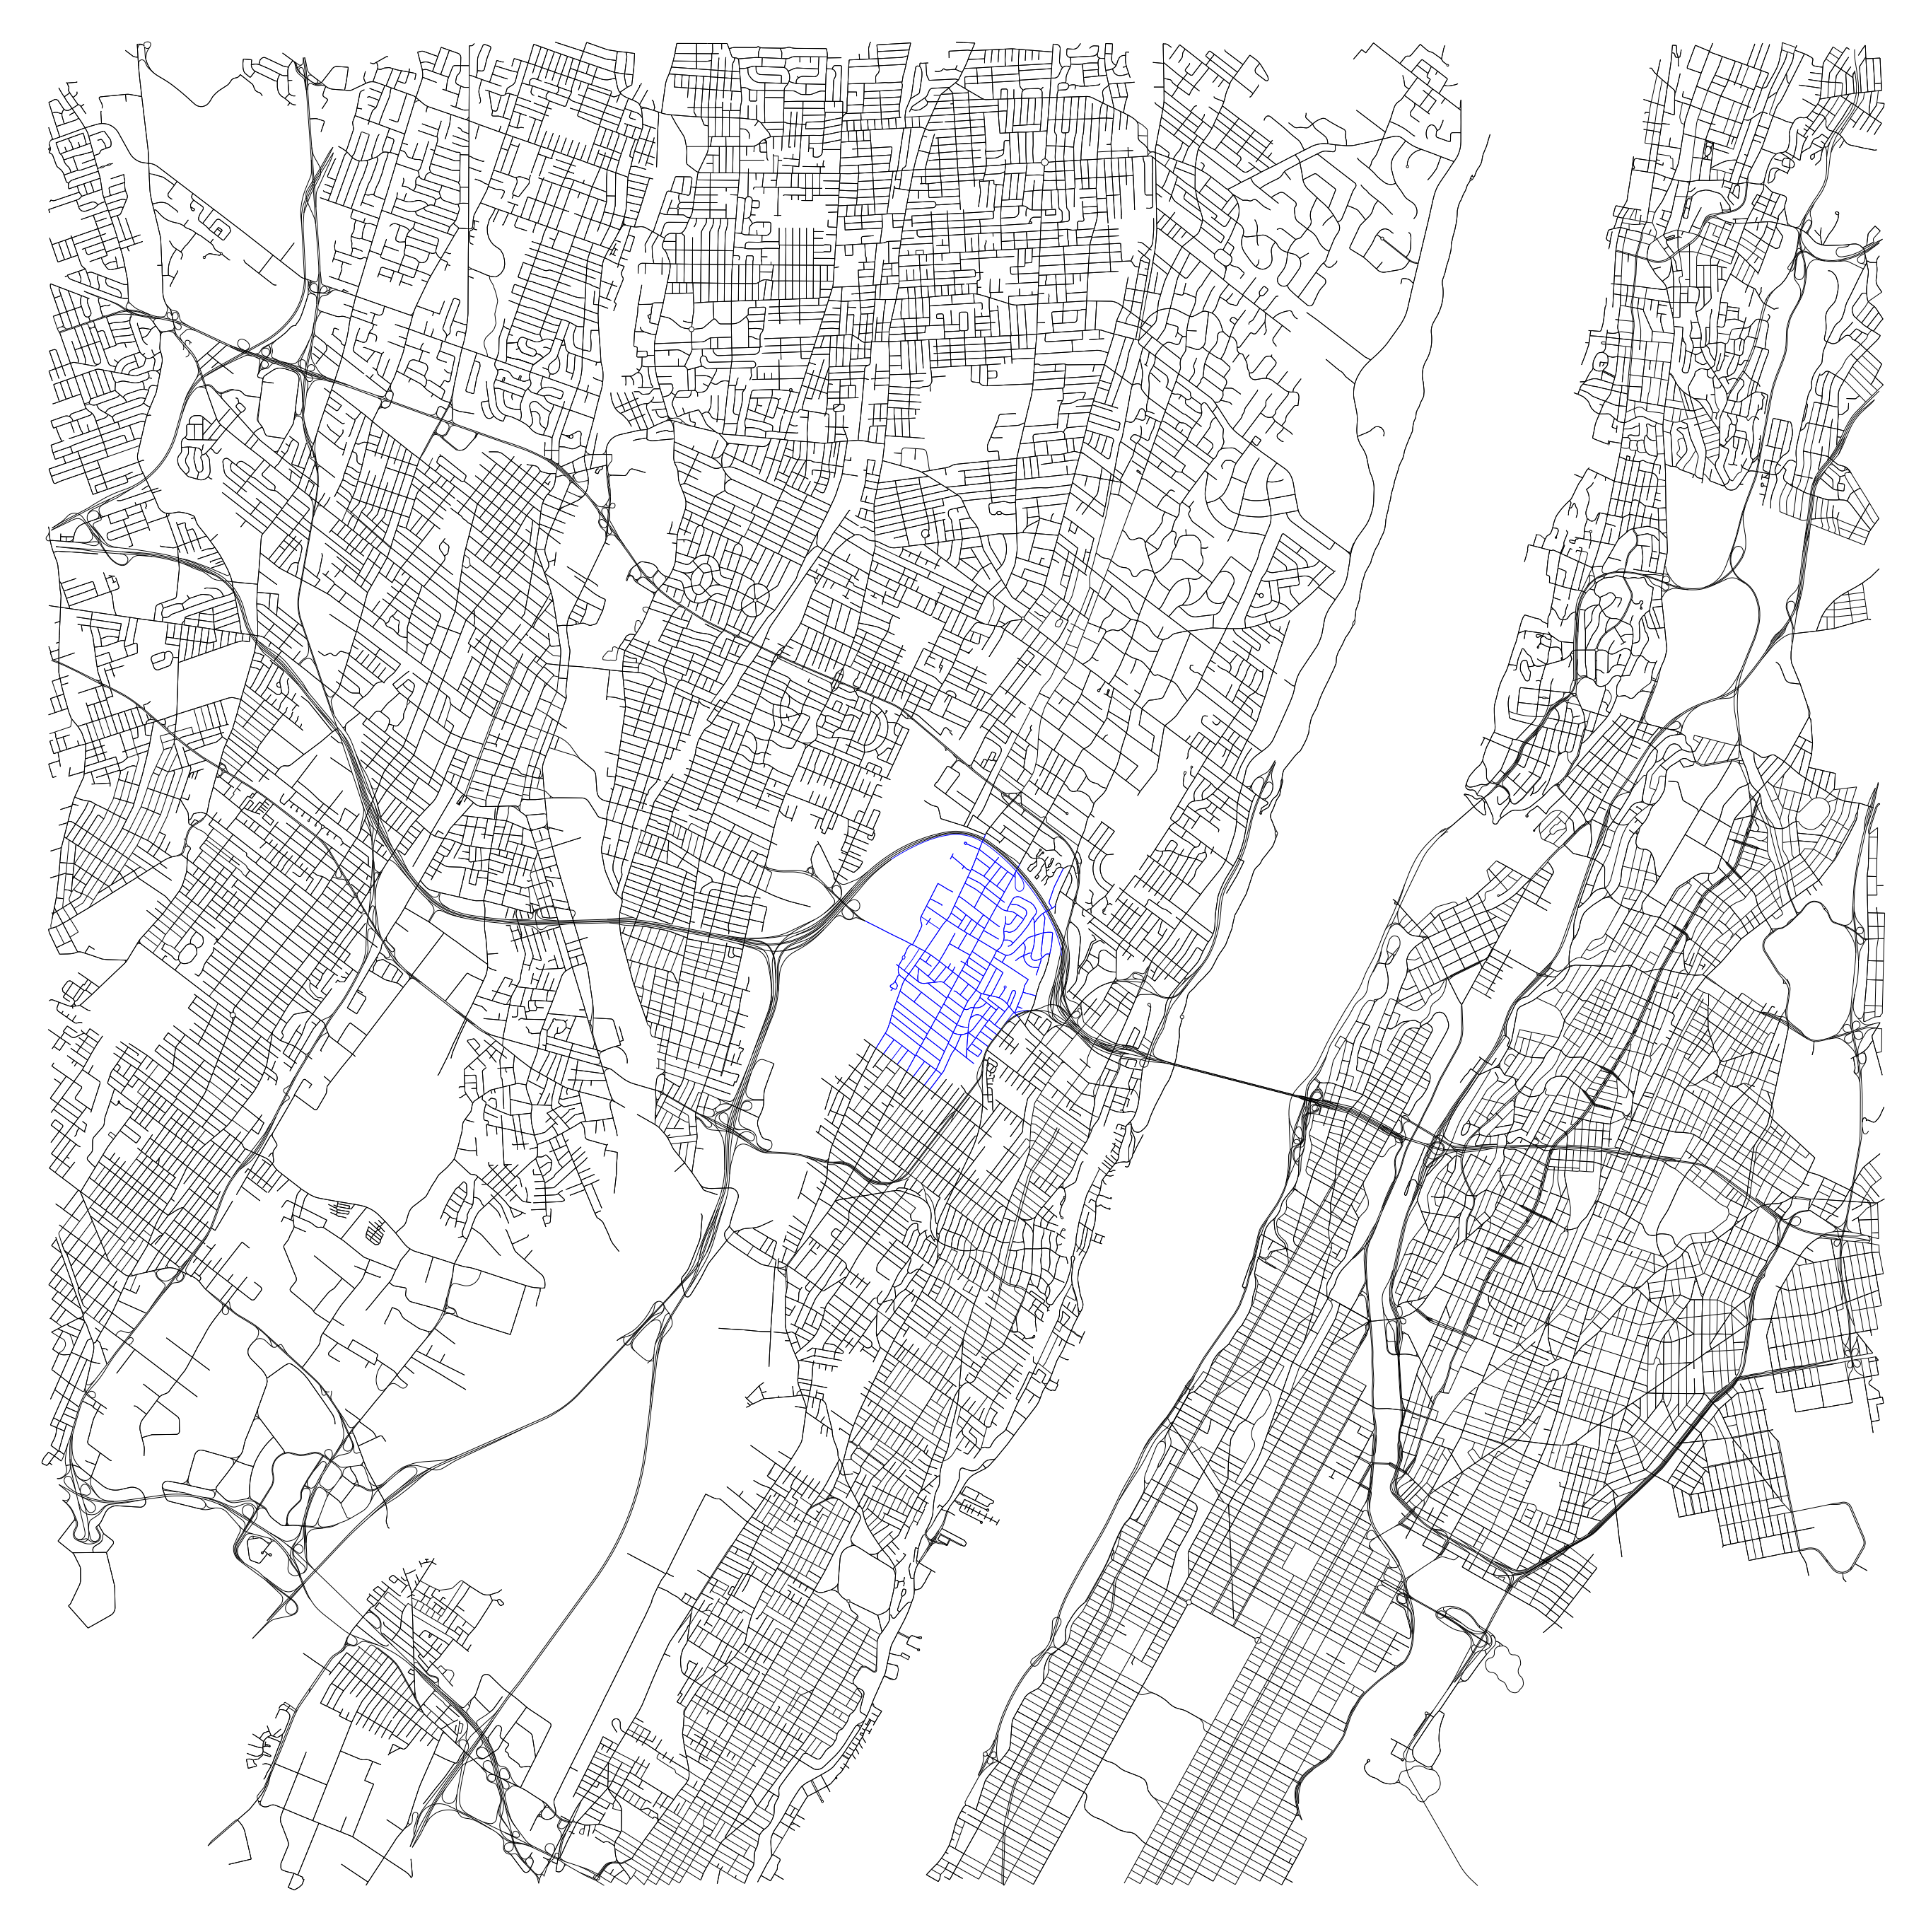

In [ ]:
# save them all
type = 'png'
# just the town and area
nodes, edges = ox.graph_to_gdfs(G)
fig, ax = ox.plot_graph(G ,fig_height=50, fig_width=50, edge_color=edges['edge_color'],  node_size=0)
fig.savefig('%s/area.%s' % (file_path,type), dpi=1000, format=type)


# just the good way (old fashioned mapped)
fig, ax = ox.plot_graph_route(G,route2, route_color=route2_color, fig_height=50, fig_width=50, 
                               edge_color=edges['edge_color'], node_size=0,
                               show=True, close=False, route_linewidth = [route_thickness,route_thickness]) 
fig.savefig('%s/1950.%s' % (file_path,type), dpi=1000, format=type)

# waze enabled
fig, ax = ox.plot_graph_route(G,route1, route_color=route1_color, fig_height=50, fig_width=50, 
                               edge_color=edges['edge_color'], node_size=0,
                               show=True, close=False, route_linewidth = [route_thickness,route_thickness]) 
fig.savefig('%s/waze.%s' % (file_path,type), dpi=1000, format=type)

# current
fig, ax = ox.plot_graph_route(G, route2, route_color=route2_color, fig_height=50, fig_width=50, 
                               edge_color=edges['edge_color2'], node_size=0,
                               show=True, close=False, route_linewidth = [route_thickness,route_thickness]) 
fig.savefig('%s/current.%s' % (file_path,type), dpi=1000, format=type)

#fix
fig, ax = ox.plot_graph_route(G, route2, route_color=rc, fig_height=50, fig_width=50, 
                               edge_color=edges['edge_color'], node_size=0,
                               show=True, close=False, route_linewidth = [route_thickness,route_thickness]) 
fig.savefig('%s/current.%s' % (file_path,type), dpi=1000, format=type)
